In [1]:
!pip install numba-cuda==0.4.0 numba==0.60 llvmlite==0.43

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: numba-cuda
    Found existing installation: numba-cuda 0.11.0
    Uninstalling numba-cuda-0.11.0:
      Successfully uninstalled numba-cuda-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires numba-cuda<0.12.0a0,>=0.11.0, but you have numba-cuda 0.4.0 which is incompatible.


In [2]:
import numba.cuda

In [3]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [4]:
numba.cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-f62a5d0c-a97e-d539-826c-0d13affdd004
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [5]:
device = numba.cuda.select_device(0)
print("name:", device.name)

free_bytes, total_bytes = numba.cuda.current_context().get_memory_info()
print("total mem:", total_bytes)
print("free mem:", free_bytes)
print("multiprocessor count:", device.MULTIPROCESSOR_COUNT)
print("compute capability:", device.compute_capability)

# compute capability 7.5 has 64 cores per processor
core_count = device.MULTIPROCESSOR_COUNT * 64
print("core count:", core_count)

name: b'Tesla T4'
total mem: 15828320256
free mem: 15720382464
multiprocessor count: 40
compute capability: (7, 5)
core count: 2560


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import urllib
from PIL import Image
import math
import time

(734, 1200, 3)


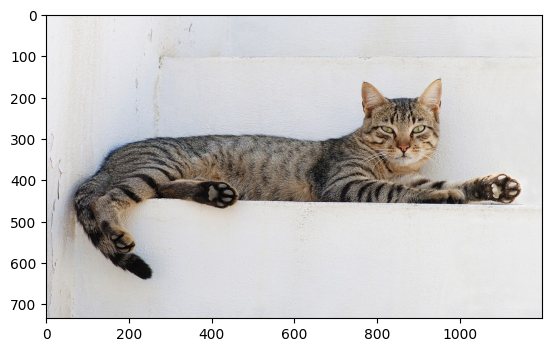

In [7]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Cat_August_2010-4.jpg/1200px-Cat_August_2010-4.jpg"
image = np.array(Image.open(urllib.request.urlopen(urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"}))))
plt.imshow(image)
print(image.shape)

In [32]:
@numba.cuda.jit
def gray_1d(src, dst):
  x = numba.cuda.threadIdx.x + numba.cuda.blockIdx.x * numba.cuda.blockDim.x
  if x < src.shape[0]:
    value = (src[x, 0] + src[x, 1] + src[x, 2]) / 3
    dst[x, 0] = value
    dst[x, 1] = value
    dst[x, 2] = value

In [245]:
flatten = image.reshape(-1, image.shape[-1])

src = numba.cuda.to_device(flatten)
dst = numba.cuda.device_array(flatten.shape, image.dtype)

block_size = 256
grid_size = math.ceil(flatten.shape[0] / block_size)
d = 0
for _ in range(10000):
  start = time.time()
  gray_1d[grid_size, block_size](src, dst)
  end = time.time()
  d += end - start
d /= 10000
print(d)

7.886135578155518e-05


In [254]:
@numba.cuda.jit
def gray_2d(src, dst):
  y = numba.cuda.threadIdx.x + numba.cuda.blockIdx.x * numba.cuda.blockDim.x
  x = numba.cuda.threadIdx.y + numba.cuda.blockIdx.y * numba.cuda.blockDim.y

  if x < src.shape[0] and y < src.shape[1]:
    value = (src[x, y, 0] + src[x, y, 1] + src[x, y, 2]) / 3
    dst[x, y, 0] = value
    dst[x, y, 1] = value
    dst[x, y, 2] = value


In [269]:
block_size = (32, 8)
grid_size = (math.ceil(image.shape[0] / block_size[0]), math.ceil(image.shape[1] / block_size[1]))

src = numba.cuda.to_device(image)
dst = numba.cuda.device_array(image.shape, image.dtype)

d1 = 0
for _ in range(10000):
  start = time.time()
  gray_2d[grid_size, block_size](src, dst)
  end = time.time()
  d1 += end - start
d1 /= 10000
print(d1)
print("speed up", d1 / d)

6.044173240661621e-05
speed up 0.7664302979274024


In [261]:
src = numba.cuda.to_device(image)
dst = numba.cuda.device_array(image.shape, image.dtype)

a = np.zeros((11, 11))
for i in range(10 + 1):
  for j in range(10 + 1):
    if (2**i) * (2**j) > 1024:
      continue
    block_size = (2**i, 2**j)
    grid_size = (math.ceil(image.shape[0] / block_size[0]), math.ceil(image.shape[1] / block_size[1]))
    t = 0
    for _ in range(1000):
      start = time.time()
      gray_2d[grid_size, block_size](src, dst)
      end = time.time()
      t += end - start
    t /= 1000
    a[i, j] = t

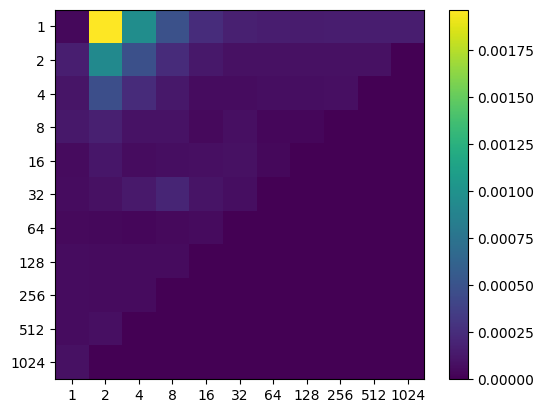

In [263]:
plt.imshow(a)
plt.colorbar()
plt.xticks(np.arange(11), [2**i for i in range(11)])
plt.yticks(np.arange(11), [2**i for i in range(11)])
plt.show()